In [1]:
import torch
import time
import torchtext
import seaborn as sns
import pandas as pd
import numpy as np


from time import strftime, localtime

# import nltk 
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split


from torch import nn
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

c:\Programs\Anaconda3\envs\NLP_p1\lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Programs\Anaconda3\envs\NLP_p1\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Programs\Anaconda3\envs\NLP_p1\lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070 Laptop GPU'

In [23]:
# Classes

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.net = nn.Sequential(
            nn.EmbeddingBag(vocab_size, embed_dim, sparse=False),
            nn.ReLU(),
            nn.Linear(embed_dim, 30),
            nn.ReLU(),
            nn.Linear(30, num_class),
            nn.Sigmoid()
        )


    def forward(self, text_batch):
        return self.net(text_batch)
    


class Classifier:
    def __init__(
            self,
            words_in_vocab,
            embedding_dim,
            number_of_classes,
            learn_rate,
            learn_rate_step,
            device = device
            ):
        self.device = device
        self.number_of_classes = number_of_classes
        self.model = TextClassificationModel(words_in_vocab, embedding_dim,
                                             number_of_classes).to(self.device)
        if number_of_classes == 2:
            self.loss_fn = nn.BCELoss()
        else:
            self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(
            self.model.parameters(), lr=learn_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, 1.0, gamma=learn_rate_step)


    def train(self, dataloader):
        self.model.train()
        total_cor_pred = 0
        total_pred = 0
        log_freq = 500
        batches_num = len(dataloader)

        for idx, (label_batch, text_batch) in enumerate(dataloader):
            labels_on_device = label_batch.to(self.device)
            texts_on_device = text_batch.to(self.device)
            self.optimizer.zero_grad()
            scores = self.model(texts_on_device)
            predicted_labels = scores.argmax(1)
            one_hot_labels = nn.functional.one_hot(labels_on_device, num_classes=self.number_of_classes)
            true_class_probs = one_hot_labels.type_as(scores)
            loss = self.loss_fn(scores, true_class_probs)
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), 0.1)
            self.optimizer.step()
            batch_cor_pred = (
                predicted_labels == labels_on_device
                ).sum().item()
            batch_pred = labels_on_device.size(0)
            total_cor_pred += batch_cor_pred
            total_pred += batch_pred
            if idx % log_freq == 0 and idx != 0:
                print(
                    f"| {idx:6d} / {batches_num:6d} batches "
                    f"| epoch_acc: {100*total_cor_pred / total_pred:.3f} % "
                    f"| batch_acc: {100*batch_cor_pred / batch_pred:.3f} % |"
                    )


    def evaluate(self, dataloader):
        labels, texts = dataloader
        self.model.eval()

        with torch.no_grad():
            labels_on_device = labels.to(self.device)
            texts_on_device = texts.to(self.device)
            scores = self.model(texts_on_device)
            predicted_labels = scores.argmax(1)
            total_cor_pred = (predicted_labels == labels_on_device).sum().item()
            total_pred = labels_on_device.size(0)

        return 100*total_cor_pred / total_pred

In [4]:
# Functions

def process_raw_text(text, tokenizer, stop_words, stemmer):
    tokens = tokenizer(text)
    processed_text = []
    for token in tokens:
        if token not in stop_words:
            processed_text.append(stemmer.stem(token))
    return processed_text


def get_token_iter(tweets, tokenizer, stop_words, stemmer):
    for tweet in tweets:
        yield process_raw_text(tweet, tokenizer, stop_words, stemmer)


def prepare_input(processed_tokens, vocab, max_inp_len):
    tensor = torch.tensor(vocab(processed_tokens))
    tensor_len = tensor.size(dim=0)
    if tensor_len < max_inp_len:
        padding = max_inp_len - tensor_len
        tensor = nn.functional.pad(tensor, (0, padding))
    elif tensor_len > max_inp_len:
        tensor = tensor[:max_inp_len]
    return tensor

In [5]:
tweet_data = pd.read_csv(
    'data/input/training.1600000.processed.noemoticon.csv',
    encoding = 'latin',
    header=None
    )
tweet_data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
tweet_data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
tweet_data[[
    'weekday',
    'month',
    'day',
    'time',
    'timezone',
    'year'
    ]] = tweet_data['date'].str.split(' ', n=5, expand=True)
tweet_data = tweet_data[['weekday', 'month', 'day', 'year',
                         'time', 'text', 'sentiment']]
tweet_data.sentiment = tweet_data.sentiment.apply(
    lambda x: 1 if x == 4 else x)
tweet_data.head()

,weekday,month,day,year,time,text,sentiment
0,Mon,Apr,06,2009,22:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,Mon,Apr,06,2009,22:19:49,is upset that he can't update his Facebook by ...,0
2,Mon,Apr,06,2009,22:19:53,@Kenichan I dived many times for the ball. Man...,0
3,Mon,Apr,06,2009,22:19:57,my whole body feels itchy and like its on fire,0
4,Mon,Apr,06,2009,22:19:57,"@nationwideclass no, it's not behaving at all....",0


<Axes: xlabel='weekday', ylabel='count'>

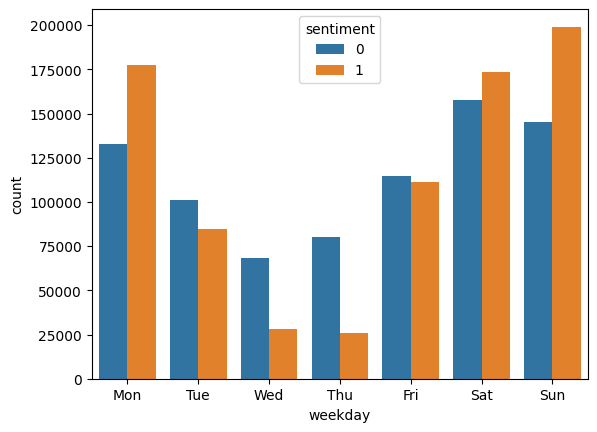

In [7]:
val_count = tweet_data.groupby('weekday')['sentiment'].value_counts()
val_count = val_count.reset_index(name='count')
sorted_weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
val_count['weekday'] = pd.Categorical(val_count['weekday'], sorted_weekdays)
sns.barplot(
    x='weekday',
    y='count',
    hue='sentiment',
    data=val_count
    )

<Axes: xlabel='sentiment'>

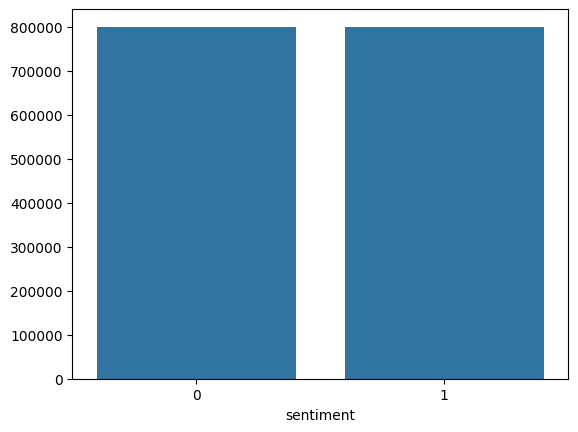

In [8]:
val_count = tweet_data['sentiment'].value_counts()
sns.barplot(
    x=val_count.index,
    y=val_count.values,
    )

In [9]:
# Prepare data
VAL_PORTION = 0.25 # of training data
TEST_PORTION = 0.1 # of all the data
data = tweet_data.text
labels = tweet_data.sentiment
tr_data, te_data, tr_labels, te_labels = train_test_split(data, labels, test_size=TEST_PORTION, random_state=1)
tr_data, val_data, tr_labels, val_labels = train_test_split(tr_data, tr_labels, test_size=VAL_PORTION, random_state=1)

In [10]:
tokenizer = get_tokenizer('basic_english')
stop_words = [] #stopwords.words('english')
stemmer = SnowballStemmer('english')
train_iter = get_token_iter(tr_data, tokenizer, stop_words, stemmer)
vocab = build_vocab_from_iterator(train_iter, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [11]:
MAX_TWEET_LENGTH = 60

# Prepare training data
tr_data_list = []
for label, raw_tweet in zip(tr_labels, tr_data):
    tokens = process_raw_text(raw_tweet, tokenizer, stop_words, stemmer)
    tweet_tensor = prepare_input(tokens, vocab, MAX_TWEET_LENGTH)
    tr_data_list.append([label, tweet_tensor])

In [25]:
BATCH_SIZE = 64 # batch size for training
train_dataloader = DataLoader(
    tr_data_list, batch_size=BATCH_SIZE, shuffle=True
)

In [12]:
# Prepare validation data
val_tensor_list = []
for raw_tweet in val_data:
    tokens = process_raw_text(raw_tweet, tokenizer, stop_words, stemmer)
    tweet_tensor = prepare_input(tokens, vocab, MAX_TWEET_LENGTH)
    val_tensor_list.append(tweet_tensor)
val_dataloader = (
    torch.tensor(val_labels.to_list()),
    torch.stack(val_tensor_list)
    )

In [13]:
# Prepare test data
te_tensor_list = []
for raw_tweet in te_data:
    tokens = process_raw_text(raw_tweet, tokenizer, stop_words, stemmer)
    tweet_tensor = prepare_input(tokens, vocab, MAX_TWEET_LENGTH)
    te_tensor_list.append(tweet_tensor)
test_dataloader = (
    torch.tensor(te_labels.to_list()),
    torch.stack(te_tensor_list)
    )

## Train

In [26]:
# Hyperparameters
EPOCHS = 10  # epoch
LR = 5  # learning rate
LR_STEP_SIZE = 0.4
VOCAB_SIZE = len(vocab)
EM_SIZE = 120

class_model = Classifier(VOCAB_SIZE, EM_SIZE, 2, LR, LR_STEP_SIZE)
total_accu = None

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    loc_time = strftime('%Y-%m-%d %H:%M:%S', localtime(epoch_start_time))
    print("-" * 71)
    print(f"| EPOCH {epoch} | TIME: {loc_time} |")
    print("-" * 71)
    class_model.train(train_dataloader)
    accu_val = class_model.evaluate(val_dataloader)
    if total_accu is not None and total_accu > accu_val:
        class_model.scheduler.step()
    else:
        total_accu = accu_val
    print("-" * 71)
    print(f"| EPOCH END | val_accuracy: {accu_val:.3f} % |")
    print("-" * 71)

----------------------------------------------------------------------
| EPOCH 1 | TIME: 2024-05-07 13:10:11 |
----------------------------------------------------------------------
|    500 /  16875 batches | epoch_acc: 50.178 % | batch_acc: 51.562 % |
|   1000 /  16875 batches | epoch_acc: 50.275 % | batch_acc: 57.812 % |
|   1500 /  16875 batches | epoch_acc: 50.141 % | batch_acc: 43.750 % |
|   2000 /  16875 batches | epoch_acc: 50.148 % | batch_acc: 48.438 % |
|   2500 /  16875 batches | epoch_acc: 50.149 % | batch_acc: 54.688 % |
|   3000 /  16875 batches | epoch_acc: 50.197 % | batch_acc: 50.000 % |
|   3500 /  16875 batches | epoch_acc: 50.200 % | batch_acc: 46.875 % |
|   4000 /  16875 batches | epoch_acc: 50.210 % | batch_acc: 60.938 % |
|   4500 /  16875 batches | epoch_acc: 50.280 % | batch_acc: 43.750 % |
|   5000 /  16875 batches | epoch_acc: 50.197 % | batch_acc: 51.562 % |
|   5500 /  16875 batches | epoch_acc: 50.183 % | batch_acc: 53.125 % |
|   6000 /  16875 batches 

## Evaluate

In [29]:
accu_test = class_model.evaluate(test_dataloader)
print("-" * 50)
print(f"TEST | test accuracy: {accu_test:.3f} %")
print("-" * 50)

--------------------------------------------------
TEST | test accuracy: 76.836 %
--------------------------------------------------


In [30]:
custom_text = [
    "Imo it's the greatest breaktrough. We can achieve so much more now!",
    "is it good or bad? I tend to believe it is kind of mediocre."
    ]
tensor_list = []
for text in custom_text:
    preproc_text = process_raw_text(text, tokenizer, stop_words, stemmer)
    print(preproc_text)
    input_tensor = prepare_input(preproc_text, vocab, 30)
    print(input_tensor)
    tensor_list.append(input_tensor)
model_input = torch.stack(tensor_list).to(device)
class_model.model(model_input)

['imo', 'it', "'", 's', 'the', 'greatest', 'breaktrough', '.', 'we', 'can', 'achiev', 'so', 'much', 'more', 'now', '!']
tensor([  5192,      9,      4,     17,      6,   2089, 139824,      1,     55,
            37,   3442,     24,    105,    104,     38,      3,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0])
['is', 'it', 'good', 'or', 'bad', '?', 'i', 'tend', 'to', 'believ', 'it', 'is', 'kind', 'of', 'mediocr', '.']
tensor([  14,    9,   39,  121,  128,   13,    2, 3190,    5,  383,    9,   14,
         503,   18, 8566,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])


tensor([[0.1095, 0.8905],
        [0.7021, 0.2979]], device='cuda:0', grad_fn=<SigmoidBackward0>)